### ARMA, lag=2, ma=0

In [2]:
import pandas as pd
import psycopg2
import yfinance as yf
import warnings
from tqdm import tqdm
import numpy as np
warnings.filterwarnings("ignore")
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
cursor = conn.cursor()
cursor.execute("SELECT distinct code from public.maincode where listed = 'us100';")
conn.commit()
code_list_1 = [i[0] for i in cursor.fetchall()]
code_list = code_list_1 + ['QQQ', "VOO"]
cursor.execute("SELECT distinct code from public.maincode where listed = 'us30';")
conn.commit()
code_list_2 = [i[0] for i in cursor.fetchall()]
code_list = code_list + code_list_2
code_list = list(set(code_list))
cursor.execute("SELECT distinct code from public.maincode where listed = 'us500';")
conn.commit()
code_list_3 = [i[0] for i in cursor.fetchall()]
code_l = [i for i in code_list_3 if i not in code_list]
code_list = code_list + code_l
code_list = list(set(code_list))
len(code_list)

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


521

In [3]:
import yfinance as yf
import pandas as pd
s = "DIA"
a = yf.download(code_list_2 + [s], start='2023-01-01', rounding=2)

weekly_returns = a['Open'].pct_change().resample("W-FRI").sum()

stdized_ret_diff = pd.DataFrame(index=weekly_returns.index)

dia_returns = weekly_returns[s]

for code in weekly_returns.columns.drop(s):
    ret_diff = weekly_returns[code] - dia_returns
    ret_diff_std = ret_diff.rolling(5).std()
    ret_diff_mean = ret_diff.rolling(5).mean()
    stdized_ret_diff[code] = abs((ret_diff - ret_diff_mean) / ret_diff_std)

stdized_ret_diff.dropna(inplace=True)

dia_returns = weekly_returns[s]
for code in weekly_returns.columns.drop(s):
    weekly_returns[code] = weekly_returns[code] - dia_returns

k = 1
res = []
for time_index, row in stdized_ret_diff.iterrows():
    a = weekly_returns.loc[time_index].apply(lambda x: k if x > 0 else -k)
    res.append(a*row)
res = pd.DataFrame(res).dropna(axis=1)


[*********************100%***********************]  31 of 31 completed


In [11]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 10
time_length = len(res)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = res.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = weekly_returns[weekly_returns.columns.intersection(res.columns)].shift(-2)

index = res.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = res.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot(title="10 quantile cumsum distribution")

[*********************100%***********************]  1 of 1 completed


2024-03-19 00:00:00


arma model for top 1, enumerate by da:   0%|          | 0/171 [00:00<?, ?it/s]/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No 

<Axes: xlabel='Date'>

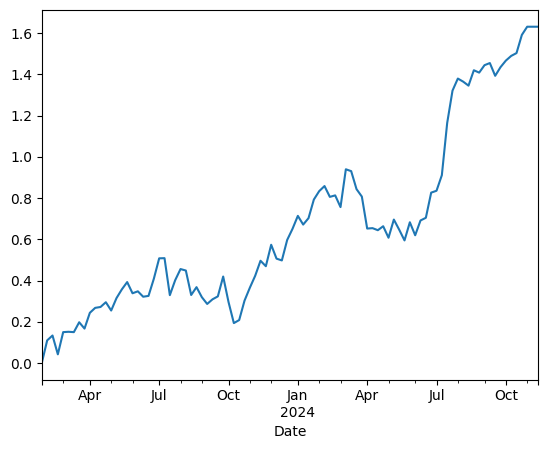

In [117]:
q = quantilized_cumsum.iloc[:, [0, -1]]
q.iloc[:, 0] = -q.iloc[:, 0]
q.sum(axis=1).plot()

In [ ]:
11/18
long: BA, UNH, MRK
short: DIS, NKE, HD(Home Depot)

In [9]:
res.iloc[-2].sort_values()[:20], res.iloc[-2].sort_values()[-20:]

(JNJ    -1.756931
 KO     -1.738593
 PG     -1.696261
 VZ     -1.539928
 MRK    -1.502041
 DOW    -1.471022
 NKE    -1.444008
 HD     -1.353264
 AMGN   -1.320571
 MCD    -1.205224
 BA     -1.070274
 WMT    -1.002884
 CVX    -0.738779
 DIS    -0.736160
 AAPL   -0.577320
 TRV    -0.325757
 MMM    -0.175541
 IBM    -0.078166
 MSFT   -0.046244
 HON     0.152752
 Name: 2024-11-08 00:00:00+00:00, dtype: float64,
 BA     -1.070274
 WMT    -1.002884
 CVX    -0.738779
 DIS    -0.736160
 AAPL   -0.577320
 TRV    -0.325757
 MMM    -0.175541
 IBM    -0.078166
 MSFT   -0.046244
 HON     0.152752
 CSCO    0.215524
 AMZN    0.242769
 V       0.280634
 AXP     0.580627
 JPM     0.851345
 UNH     0.923246
 CRM     1.147091
 INTC    1.416063
 CAT     1.586438
 GS      1.700655
 Name: 2024-11-08 00:00:00+00:00, dtype: float64)

In [138]:
# FFT: PPG
# 50: JNJ
# 10: PNC
# 15: QCOM, TSLA, CME
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

LIST_0 = ['AMZN', 'AMD', 'BA', 'SBUX', "WMT", "GE", "MSFT", "PEP", "MMM", "ABNB", "ADI", "NVDA", "PPG", "PAYX", "AVGO", "TJX", "JPM", "LEN"]
LIST_1 = ['MPC', "MRVL", "MS", "PG", "WFC", "PCAR", "BMO", "CVX", "CHRW", "CNI", "COP", "DELL", "DUK", 'FSLR']
LIST_2 = ["HES", "CAH", "EMN", "ENTG", "HIG", "INGR", "PM", "PDD", "PHM", "AXP", "EXPE", "HON", "IBM", "NTAP"]
FFT = ['KMB']
LIST_50 = ['MRK', 'DHR', "ABBV", "BPMC", "DVA", "IDXX", "MDT", "RGEN"] 

list_ = LIST_0 + LIST_1 + LIST_2 + LIST_50 + FFT
import yfinance as yf
df = yf.download(list_, start='2023-01-01', interval='1d', progress=False, ignore_tz=True, rounding=2)
pct_close_w = df['Close'].pct_change().dropna().resample("W-FRI").sum()

In [127]:

indexes = pct_close_w.index
tickers = pct_close_w.iloc[:, :].columns
indices = indexes[52:]
forecast = np.zeros((len(indices), len(tickers)))
print(indices[0])
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {len(tickers)}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(len(tickers)):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = sm.tsa.arima.ARIMA(series, order=(2, 0, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast().values[0]
        forecast[index, i] = prediction
factor = pd.DataFrame(forecast, columns=tickers, index=indices)


2024-01-05 00:00:00+00:00


arma model for top 55, enumerate by da: 100%|██████████| 46/46 [00:39<00:00,  1.17it/s]


<Axes: title={'center': '10 quantile cumsum distribution'}, xlabel='Date'>

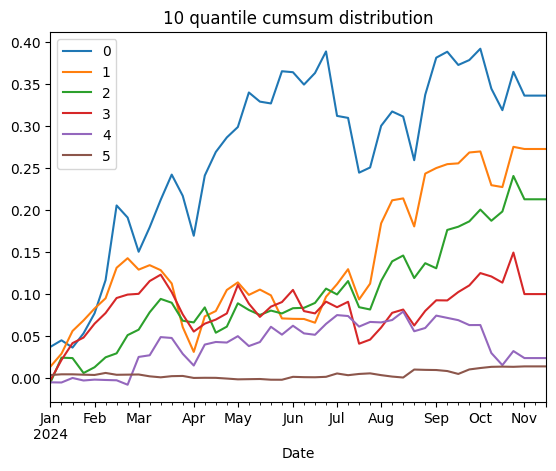

In [137]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 6
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-2)

index = factor.index
list_corr = []
list_short_corr = []
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot(title="10 quantile cumsum distribution")

In [133]:
factor.iloc[-1].sort_values()

Ticker
EXPE   -0.013460
RGEN   -0.011693
HON    -0.011531
HES    -0.011412
BA     -0.010002
JPM    -0.009005
AMD    -0.008974
WFC    -0.008839
CVX    -0.006365
TJX    -0.005358
NTAP   -0.005285
MRVL   -0.004729
AMZN   -0.002638
COP    -0.002346
PEP    -0.001980
CNI    -0.001840
SBUX   -0.001743
MRK    -0.001121
MS     -0.001098
BMO    -0.000963
ABNB   -0.000358
PG      0.000563
PDD     0.000851
HIG     0.001170
PPG     0.002029
MSFT    0.002958
CAH     0.003994
IDXX    0.004277
KMB     0.004723
MPC     0.004735
MDT     0.004810
BPMC    0.004950
DUK     0.005444
EMN     0.005499
PHM     0.005564
ABBV    0.005574
IBM     0.005986
DHR     0.006350
ENTG    0.006420
LEN     0.006616
AXP     0.006939
PCAR    0.007729
WMT     0.009752
PAYX    0.009784
CHRW    0.010626
PM      0.011074
DVA     0.011478
DELL    0.012184
MMM     0.014644
FSLR    0.014986
ADI     0.017739
GE      0.021724
AVGO    0.024250
NVDA    0.026900
INGR    0.035670
Name: 2024-11-15 00:00:00+00:00, dtype: float64

<Axes: xlabel='Ticker', ylabel='Ticker'>

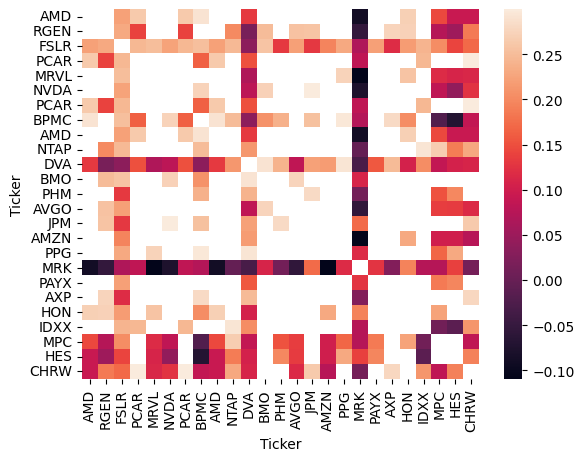

In [9]:
list_garch = ['AMD', 'RGEN', 'FSLR', 'PCAR', 'MRVL']
list_corr = ['NVDA', 'PCAR', 'BPMC', 'AMD', 'NTAP', 'DVA', 'BMO', 'PHM', 'AVGO', 'JPM']
list_short_Corr = ['AMZN', 'PPG', 'MRK', 'PAYX', 'AXP', 'HON', 'IDXX', 'MPC', 'HES', 'CHRW']
a = list_garch + list_corr + list_short_Corr
cor = pct_close_w[a].corr()
import seaborn as sns
sns.heatmap(cor[cor <= 0.3])

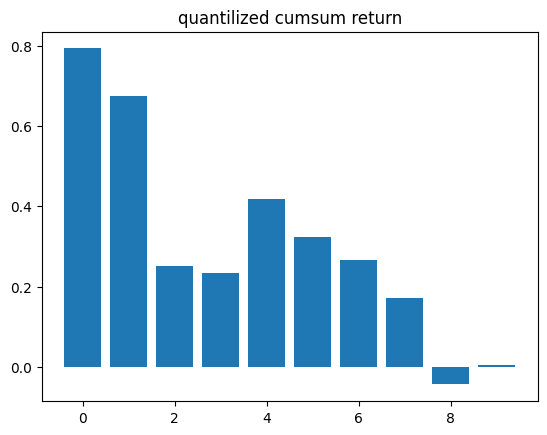

In [69]:
"""
0: AR預測值最高; 9: 最低 (number of stocks in thje stock pool: 1013; stocks per quantile: 100, 等權做多報酬)
"""
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()
